In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.9'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 40
accelerator = 'auto'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (562, 2) , valid data shape:  (40, 2)


,date,ta
557,2021-07-11,125957
558,2021-07-12,139012
559,2021-07-13,127014
560,2021-07-14,118241
561,2021-07-15,114358


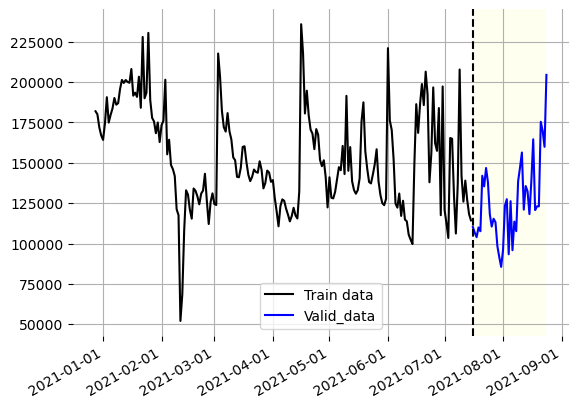

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data'],
    # date_fmt='%Y-%m-%d %H:%M:%S'  # 支持指定时间格式
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest',
 'tide',
 'seg_rnn',
 'prophet']

In [10]:
# If you want to try multiple configurations of a model at once for comparison or tuning purposes, you can use `PipelineConfigs`.
# This feature allows for customizing the models returned by each `ModelPipeline.list_all_available_models()` call.
# The first one is the name of the model, which needs to be in the list of available models provided by PipelineTS.list_all_available_models(). 
# If you want to customize the name of the model, then the second argument can be a string of the model name, 
# otherwise, the second one is of type dict. The dict can have three keys: 'init_configs', 'fit_configs', 'predict_configs', or any combination of them. 
# The remaining keys will be automatically filled with default parameters.
# Among them, 'init_configs' represents the initialization parameters of the model, 'fit_configs' represents the parameters during model training, 
# and 'predict_configs' represents the parameters during model prediction.

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pipeline_configs = PipelineConfigs([
    ('lightgbm', 'lightgbm_linear_tree', {'init_configs': {'verbose': -1, 'linear_tree': True}}),
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    ('multi_output_model', {
        'init_configs': {'estimator': XGBRegressor, 'random_state': 42, 'kwargs': {'verbosity': 0}}
    }
     ),
    ('multi_output_model', {
        'init_configs': {'estimator': CatBoostRegressor, 'random_state': 42, 'verbose': False}
    }
     ),
])

,model_name,model_name_after_rename,model_configs
0,lightgbm,lightgbm_linear_tree,"{'init_configs': {'verbose': -1, 'linear_tree': True}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
2,multi_output_model,multi_output_model_2,"{'init_configs': {'estimator': <class 'xgboost.sklearn.XGBRegressor'>, 'random_state': 42, 'kwargs': {'verbosity': 0}}, 'fit_configs': {}, 'predict_configs': {}}"
3,multi_output_model,multi_output_model_3,"{'init_configs': {'estimator': <class 'catboost.core.CatBoostRegressor'>, 'random_state': 42, 'verbose': False}, 'fit_configs': {}, 'predict_configs': {}}"
4,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


In [14]:
from sklearn.metrics import mean_absolute_error
pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    # include_models=['d_linear', 'random_forest', 'n_linear', 'n_beats'],  # specifying the model used
    # exclude_models=['catboost', 'tcn', 'transformer'],  # exclude specified models
    accelerator=accelerator,
    # Now we can directly input the "modelname__'init_params'" parameter to instantiate the models in ModelPipeline.
    # Note that it is double underline. 
    # When it is duplicated with the ModelPipeline class keyword parameter, the ModelPipeline clas keyword parameter is ignored
    d_linear__lags=50,
    n_linear__random_state=1024,
    n_beats__num_blocks=3,
    random_forest__n_estimators=200,
    n_hits__accelerator='cpu', # Since using mps backend for n_hits model on mac gives an error, cpu backend is used as an alternative
    tft__accelerator='cpu', # tft, same question, but if you use cuda backend, you can just ignore this two configurations.
)

In [15]:
pipeline.fit(data, valid_data=valid_data)

00:02:03 2023-10-31 - PipelineTS - There are a total of 21 models to be trained.
00:02:03 2023-10-31 - PipelineTS - [model  0] fitting and evaluating auto_arima...
00:02:20 2023-10-31 - PipelineTS - [model  1] fitting and evaluating catboost...
00:04:23 2023-10-31 - PipelineTS - [model  2] fitting and evaluating d_linear...
00:04:42 2023-10-31 - PipelineTS - [model  3] fitting and evaluating gau...
00:05:24 2023-10-31 - PipelineTS - [model  4] fitting and evaluating lightgbm...
00:05:51 2023-10-31 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
00:06:15 2023-10-31 - PipelineTS - [model  6] fitting and evaluating multi_step_model_1...
00:06:25 2023-10-31 - PipelineTS - [model  7] fitting and evaluating n_beats...
00:07:09 2023-10-31 - PipelineTS - [model  8] fitting and evaluating n_hits...
00:07:28 2023-10-31 - PipelineTS - [model  9] fitting and evaluating n_linear...
00:07:45 2023-10-31 - PipelineTS - [model 10] fitting and evaluating prophet...
00:07:54 2023

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,n_beats,34.646369,0.059747,19069.059570
1,prophet,0.138782,0.051289,20629.311013
2,tide,23.431428,0.216658,23696.607813
3,n_hits,9.325426,0.033750,25226.286719
4,auto_arima,7.756622,0.020398,26842.097945
5,stacking_rnn,26.621114,0.042770,27262.620820
6,catboost,112.798252,0.075103,30901.968223
7,lightgbm,17.387409,0.058306,31030.781881
8,time2vec,660.851591,0.158157,31855.789570
9,random_forest,4.941030,0.023574,33131.801214


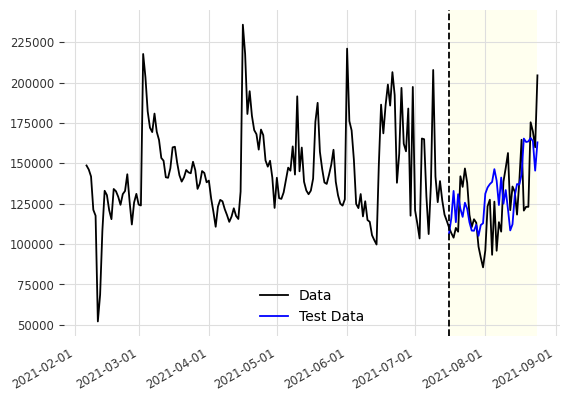

In [16]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [17]:
# Gets all configurations for the specified model， default to best model
pipeline.get_model_all_configs()

{'model_configs': {'input_chunk_length': 60,
  'output_chunk_length': 60,
  'generic_architecture': False,
  'num_stacks': 30,
  'num_blocks': 3,
  'num_layers': 4,
  'layer_widths': 256,
  'expansion_coefficient_dim': 5,
  'trend_polynomial_degree': 2,
  'dropout': 0.0,
  'activation': 'ReLU',
  'loss_fn': MSELoss(),
  'torch_metrics': None,
  'optimizer_cls': torch.optim.adam.Adam,
  'optimizer_kwargs': None,
  'lr_scheduler_cls': None,
  'lr_scheduler_kwargs': None,
  'use_reversible_instance_norm': False,
  'batch_size': 32,
  'n_epochs': 100,
  'nr_epochs_val_period': 1,
  'add_encoders': None,
  'pl_trainer_kwargs': {'accelerator': 'auto',
   'enable_progress_bar': False,
   'enable_model_summary': False},
  'random_state': 42},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'enable_progress_bar': False,
 'enable_model_summary': False}

## Model saving and reloading

In [18]:
from PipelineTS.io import *

In [19]:
save_model('pipeline.zip', pipeline)
pipeline2 = load_model('pipeline.zip')

In [20]:
pipeline2.best_model_

In [21]:
# Gets all configurations for the specified model， default to best model
pipeline2.get_model_all_configs()

{'model_configs': {'input_chunk_length': 60,
  'output_chunk_length': 60,
  'generic_architecture': False,
  'num_stacks': 30,
  'num_blocks': 3,
  'num_layers': 4,
  'layer_widths': 256,
  'expansion_coefficient_dim': 5,
  'trend_polynomial_degree': 2,
  'dropout': 0.0,
  'activation': 'ReLU',
  'loss_fn': MSELoss(),
  'torch_metrics': None,
  'optimizer_cls': torch.optim.adam.Adam,
  'optimizer_kwargs': None,
  'lr_scheduler_cls': None,
  'lr_scheduler_kwargs': None,
  'use_reversible_instance_norm': False,
  'batch_size': 32,
  'n_epochs': 100,
  'nr_epochs_val_period': 1,
  'add_encoders': None,
  'pl_trainer_kwargs': {'accelerator': 'auto',
   'enable_progress_bar': False,
   'enable_model_summary': False},
  'random_state': 42},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'enable_progress_bar': False,
 'enable_model_summary': False}

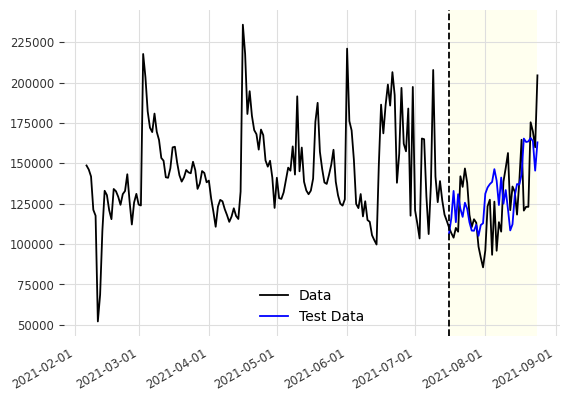

In [22]:
prediction = pipeline2.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)